### Change TensorFlow version

In [ ]:
#!pip install tensorflow==2.9.1
import tensorflow as tf
print(tf.__version__)

2.9.1


### Upload zip file containing data and arrange them into directories needed by the model. Import OS and ZipFile to assist with that.

In [ ]:
import os
import zipfile
local_zip = '/content/archive.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/lungs')
zip_ref.close()

In [ ]:
base_dir = '/content/lungs/Data'
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

train_dir_norm = os.path.join(train_dir, 'normal')
train_dir_AC = os.path.join(train_dir, 'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib')
train_dir_LCC = os.path.join(train_dir, 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa')
train_dir_SCC = os.path.join(train_dir, 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa')

valid_dir_norm = os.path.join(valid_dir, 'normal')
valid_dir_AC = os.path.join(valid_dir, 'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib')
valid_dir_LCC = os.path.join(valid_dir, 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa')
valid_dir_SCC = os.path.join(valid_dir, 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa')

test_dir_norm = os.path.join(test_dir, 'normal')
test_dir_AC = os.path.join(test_dir, 'adenocarcinoma')
test_dir_LCC = os.path.join(test_dir, 'large.cell.carcinoma')
test_dir_SCC = os.path.join(test_dir, 'squamous.cell.carcinoma')

In [ ]:
print(len(os.listdir(train_dir_norm)))
print(len(os.listdir(train_dir_AC)))
print(len(os.listdir(train_dir_LCC)))
print(len(os.listdir(train_dir_SCC)))
print()
print(len(os.listdir(valid_dir_norm)))
print(len(os.listdir(valid_dir_AC)))
print(len(os.listdir(valid_dir_LCC)))
print(len(os.listdir(valid_dir_SCC)))
print()
print(len(os.listdir(test_dir_norm)))
print(len(os.listdir(test_dir_AC)))
print(len(os.listdir(test_dir_LCC)))
print(len(os.listdir(test_dir_SCC)))

### To train model using transfer learning, import the model (in this case EfficientNetB2) and its preprocessing function.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.applications import efficientnet

In [ ]:
batch_size = 32

train_datagen = ImageDataGenerator(dtype = 'float32', preprocessing_function = efficientnet.preprocess_input)
train_generator = train_datagen.flow_from_directory(train_dir, batch_size = batch_size, target_size = (500,500),
                                                    class_mode = 'categorical')

valid_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=efficientnet.preprocess_input)
valid_generator = valid_datagen.flow_from_directory(valid_dir, batch_size = batch_size, target_size = (500,500),
                                                    class_mode = 'categorical')

test_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=efficientnet.preprocess_input)
test_generator = test_datagen.flow_from_directory(test_dir, batch_size = batch_size, target_size = (500,500),
                                                  class_mode = 'categorical')

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


### To specialize the pre-trained model to our needs, load it without the top layer, freeze the rest and create a custom top.

In [ ]:
ai_model = EfficientNetB2(include_top = False, pooling = 'avg', weights = 'imagenet', input_shape = (500,500,3))
for layer in ai_model.layers:
    layer.trainable = False

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, BatchNormalization

In [ ]:
model = Sequential()
model.add(ai_model)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(4, activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional)  (None, 1408)             7768569   
                                                                 
 flatten_3 (Flatten)         (None, 1408)              0         
                                                                 
 batch_normalization_3 (Batc  (None, 1408)             5632      
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 4)                 5636      
                                                                 
Total params: 7,779,837
Trainable params: 8,452
Non-trainable params: 7,771,385
_________________________________________________________________


### Compile the model and run!

In [ ]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics = ['acc'])

In [ ]:
hist = model.fit(train_generator, steps_per_epoch = 20, epochs = 50, verbose = 1, validation_data = valid_generator)

Epoch 1/50
20/20 [==============================] - 20s 621ms/step - loss: 1.1405 - acc: 0.5090 - val_loss: 1.1321 - val_acc: 0.4861
Epoch 2/50
20/20 [==============================] - 10s 498ms/step - loss: 0.6366 - acc: 0.7423 - val_loss: 1.0950 - val_acc: 0.5139
Epoch 3/50
20/20 [==============================] - 10s 466ms/step - loss: 0.4846 - acc: 0.8140 - val_loss: 1.1319 - val_acc: 0.5000
Epoch 4/50
20/20 [==============================] - 10s 493ms/step - loss: 0.3874 - acc: 0.8662 - val_loss: 1.1329 - val_acc: 0.5556
Epoch 5/50
20/20 [==============================] - 10s 485ms/step - loss: 0.3347 - acc: 0.8972 - val_loss: 1.0116 - val_acc: 0.5278
Epoch 6/50
20/20 [==============================] - 9s 463ms/step - loss: 0.3073 - acc: 0.9005 - val_loss: 0.9460 - val_acc: 0.5972
Epoch 7/50
20/20 [==============================] - 10s 498ms/step - loss: 0.2511 - acc: 0.9266 - val_loss: 0.8658 - val_acc: 0.6111
Epoch 8/50
20/20 [==============================] - 10s 494ms/step - l

### Track the loss and accuracy across epochs using graphs.

<Figure size 640x480 with 0 Axes>

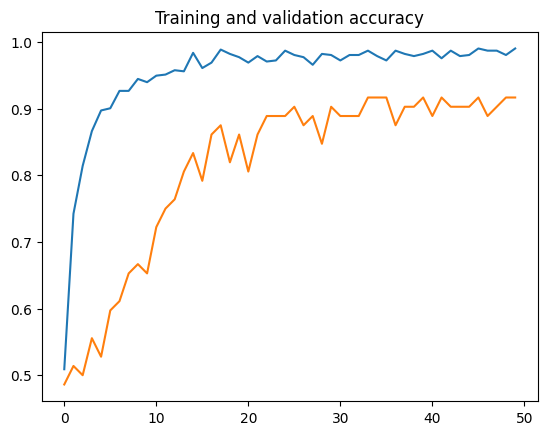

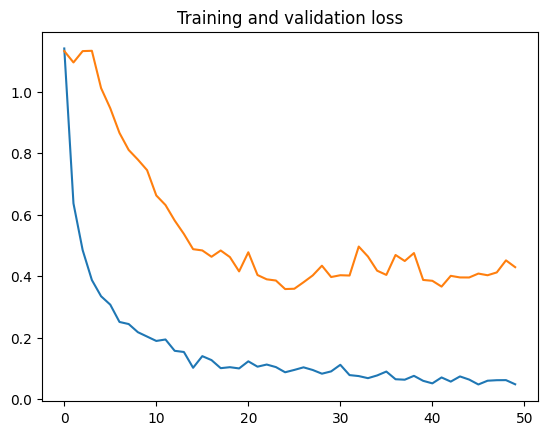

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

acc = hist.history['acc']
val_acc = hist.history['val_acc']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')
plt.figure()

plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')
plt.figure()

### Test the model against the test data.

In [ ]:
result = model.evaluate(test_generator)

10/10 [==============================] - 4s 404ms/step - loss: 0.4801 - acc: 0.8508


### Save the model as a .h5 file.

In [ ]:
model.save("ai_model.h5")
print("Model Saved!")

Model Saved!
